In [1]:
using Pkg

Pkg.activate("../Project.toml")

using Random
import .Iterators: cycle, Cycle, take

using JLD2
using CUDA
using Statistics
using Random

import Base: length, size, iterate, eltype, IteratorSize, IteratorEltype, haslength, @propagate_inbounds, repeat, rand, tail
using Plots; default(fmt=:png,ls=:auto)

import Knet
using Knet: deconv4, conv4, unpool, pool, mat, sigm, KnetArray, nll, zeroone, progress, adam!, sgd!, param, param0, dropout, relu, minibatch, Data
import Knet: train!
using Knet

 Activating environment at `~/yolo-julia/Project.toml`
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


In [2]:
include("../coco2014.jl")

od = load_data("../dataset/overfit_data.jld2");


┌ Info: Loaded: ../dataset/overfit_data.jld2.
└ @ Main /home/ec2-user/yolo-julia/coco2014.jl:43


In [3]:
dtrn = minibatch(od.x[:, :, :, 1:90], od.y[1:90], 8; xsize = (416,416,3,:), xtype=Knet.atype(), shuffle=true);
dtst = minibatch(od.x[:, :, :, 90:end], od.y[90:end], 2; xsize = (416,416,3,:), xtype=Knet.atype());


In [ ]:
include("../models.jl")

Random.seed!(1)
darknet = Darknet("../yolov3.cfg"; verbose=false);

xx, yy = first(dtrn)

# @diff a = darknet(xx, yy)

out = darknet(xx, training=false);

In [ ]:
function train!(model, train_data::Data, test_data::Data;
                  period::Int=4, iters::Int=100, lr=0.15, optimizer=sgd!)  # or optimizer=adam!
    
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []
    
    for i in 0:period:iters
        push!(train_loss, model(train_data))
        push!(test_loss, model(test_data))
        
        optimizer(model, take(cycle(train_data), period); lr=lr)
        
        
        println("Iter: ", i, " ", train_loss[end])
    end
    
    return 0:period:iters, train_loss, train_acc, test_loss, test_acc
end

In [ ]:
iters, trnloss, trnacc, tstloss, tstacc = train!(
    darknet, dtrn, dtst; 
    period=1, iters=1000, lr=1e-3, optimizer=adam!);


In [ ]:
function save_model(model::Darknet, filename::String)
    FileIO.save(filename, "darknet59", model)
    @info "Saved to: $filename."
end

save_model(darknet, "../overfit_model_20201228.jld2")

In [9]:
Random.seed!(1)

include("../models.jl")
include("../utils/train_utils.jl")

model = nothing
# model = Darknet("../yolov3.cfg"; verbose=false);
model = load_model("../overfit_model_20201228.jld2");

trn_loss, val_loss = train!(model, dtrn, dtst, epoch=200, period=10, filename="../overfit_data_20201228-1540.jld2");

# model = Darknet("../yolov3.cfg"; verbose=false);

# import ProgressMeter

# function train!(model, train_data::Data, val_data::Data;
#                   period::Int=1, epoch::Int=10, lr=0.001, optimizer=adam!)  # or optimizer=adam!
    
#     train_loss = []
#     val_loss = []
#     train_acc = []
#     val_acc = []
#     push!(train_loss, model(train_data))
#     push!(val_loss, model(val_data))
    
#     p = ProgressMeter.Progress(length(files), 1)
    
#     for ep in 1:epoch
#         for i in 1:period:length(train_data)
        
#             optimizer(model, take(cycle(train_data), period); lr=lr)
    
#             push!(train_loss, model(train_data))
#             push!(val_loss, model(val_data))
            
#             println("epoch: $ep, iter: $i, trnloss: ", train_loss[end], " valloss: ", val_loss[end])
#         end
#     end
    
#     return train_loss, train_acc, val_loss, val_acc
# end

# train_loss, train_acc, test_loss, test_acc = train!(model, dtrn, dtst, epoch=1)

┌ Info: Loaded: ../overfit_model_20201228.jld2.
└ @ Main /home/ec2-user/yolo-julia/models.jl:263
┣████████████████████┫ [100.00%, 2200/2200, 02:07:38/02:07:38, 3.48s/i] tl: 2.98, vl: 719.82, bl: 574.422


(Any[23.11343284450471, 17.808659279373558, 126.76409091113642, 59828.55354679844, 395238.23689903435, 153780.43654136482, 63966.06744949512, 45415.459097561405, 8466.50963603594, 2828.0902299710833  …  2.848341807524187, 2.81039992530301, 3.010591492413077, 2.942290845734533, 3.082187048415018, 3.095640910019336, 2.7630231030552057, 3.06059959351318, 2.9611645072917665, 2.97708208760543], Any[], Any[582.8436764010637, 589.1060250094533, 939.0893631903903, 110417.90960321997, 830582.1932684832, 255731.35573754404, 137035.32457828237, 98118.16483882736, 20232.254147350668, 6937.871737511217  …  728.6854220966919, 728.0736106519475, 735.4632140935436, 726.5286460324004, 725.7525853870735, 731.1201315500884, 724.5538704215884, 717.071935593076, 719.8167394337877, 719.8167394337877], Any[])

In [11]:
save_model(model, "../overfit_data_20201228-1540_final.jld2")

┌ Info: Saved to: ../overfit_data_20201228-1540_final.jld2.
└ @ Main /home/ec2-user/yolo-julia/models.jl:258


In [91]:
out = model(xx, yy, training=true)

1.9963998768408782

In [36]:
out_cpu = convert(Array{Float32}, out)
filtered = out_cpu[:, out_cpu[5, :, 1] .> 0.5, 1]

85×31 Array{Float32,2}:
 242.945        291.431        268.375        …  238.658        223.255
 243.655        262.825         81.9087          191.116        370.256
  54.6803       192.501         18.2013           13.1865        17.0662
  61.1116        23.0221        31.6788           23.387         25.3748
   0.992691       0.902801       0.999496          0.643118       0.662139
   0.99993        0.874399       0.999947     …    0.9994         0.999986
   0.0823459      0.000922259    1.93577f-6        0.000239091    3.58146f-5
   0.00889071     0.000399813    0.020687          0.0319414      0.00236929
   1.15098f-5     0.00382167     1.35588f-6        2.14522f-5     1.59703f-5
   0.243103       0.000832209    9.29108f-5        0.000126309    0.00431299
   0.000392775    3.69701f-5     6.03354f-7   …    2.2903f-5      5.73708f-6
   0.00306993     0.44296        8.97564f-7        4.41749f-5     4.00593f-6
   0.291506       0.0430312      0.00262217        0.0125149      0.002441

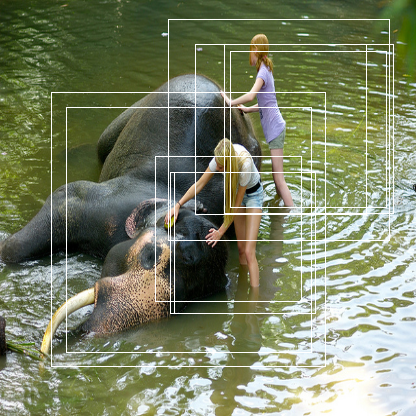

In [114]:
using Images

include("../utils/img.jl")
out = model(xx, training=false)
out_cpu = convert(Array{Float32}, out)

xx_cpu = convert(Array{Float32}, xx);

# Images.@view xx_cpu[:, :, :, 1]

# img = RGB.(255*xx_cpu[:, :, :, 1])

a = 7
A = permutedims(xx_cpu[:, :, :, a], (3,1,2))
img = colorview(RGB, A)
filtered = out_cpu[1:4, out_cpu[5, :, a] .> 0.6, a]

function get_x1y1x2y2_(label, img_size=(416, 416))
    x1 = Integer(round((label[1] - label[3]/2)))
    y1 = Integer(round((label[2] - label[4]/2)))
    x2 = Integer(round((label[1] + label[3]/2)))
    y2 = Integer(round((label[2] + label[4]/2)))

    return (x1, y1, x2, y2)
end

for i in 1:size(filtered)[2]
    y1, x1, y2, x2 = get_x1y1x2y2_(filtered[:, i][:])
    pol = get_polygon(x1, y1, x2, y2)
    img = ImageDraw.draw(img, pol)
end

img

In [107]:

function (c::Darknet)(x; training=true)
    img_size = size(x)[1:2]
    yolo_out, out = [], []

    if c.verbose; println("0 ", size(x)); end

    for (i, layer) in enumerate(c.module_list)
        layer_type = typeof(layer)

        if layer_type in [NN.FeatureConcat, NN.WeightedFeatureFusion]
            x = layer(x, out)

        elseif layer_type == NN.YOLOLayer
            push!(yolo_out, layer(x, out))
        else
            x = layer(x)
        end

        push!(out, c.routes[i] ? x : [])

        if c.verbose
            println(typeof(x))
            println("$i /$(length(c.module_list)) $layer_type ", size(x))
        end
    end

    if training
        return yolo_out
    else

        results = nothing

        for (i, out) in enumerate(yolo_out)
            layer_id = c.yolo_layers[i]

            no, ny, nx, na, bs = size(out)

            yv, xv = meshgrid(1:ny, 1:nx)
            grid = cat(yv, xv, dims=3)
            grid = permutedims(grid, (3, 1, 2))
            grid = reshape(grid, (2, ny, nx, 1, 1))
            grid = convert(c.atype, grid)

            io = deepcopy(out)
            io[1:2,:,:,:,:] = sigm.(io[1:2,:,:,:,:]) .+ grid
            io[3:4,:,:,:,:] = exp.(io[3:4,:,:,:,:]) .* c.module_list[layer_id].anchor_wh
            io[3,:,:,:,:] = io[4,:,:,:,:]
            io[4,:,:,:,:] = io[3,:,:,:,:]
            io[1:4,:,:,:,:] = io[1:4,:,:,:,:] .* c.module_list[layer_id].stride
            io[5:end,:,:,:,:] = sigm.(io[5:end,:,:,:,:])

            r = reshape(io, (no, :, bs))

            if results == nothing
                results = r
            else
                results = cat(results, r, dims=2)
            end
        end

        return results

    end
end


In [13]:
xx, yy = first(dtrn)

(K32(416,416,3,8)[0.011764706⋯], Any[Any[Any[1.0, 0.508533, 0.507469, 0.131667, 0.170594], Any[1.0, 0.234765, 0.563812, 0.051878, 0.100531], Any[1.0, 0.184155, 0.582359, 0.045915, 0.076], Any[1.0, 0.151197, 0.573375, 0.028592, 0.044719], Any[1.0, 0.438462, 0.555258, 0.030117, 0.045516], Any[1.0, 0.418404, 0.558211, 0.029953, 0.045922], Any[1.0, 0.386279, 0.564883, 0.021526, 0.027797], Any[37.0, 0.505587, 0.597133, 0.074977, 0.018359], Any[1.0, 0.090704, 0.60043, 0.040939, 0.040453], Any[1.0, 0.107207, 0.57493, 0.029671, 0.043047], Any[1.0, 0.210974, 0.568453, 0.020493, 0.040438], Any[1.0, 0.277523, 0.57332, 0.014718, 0.021359], Any[1.0, 0.299824, 0.56875, 0.011526, 0.021844], Any[14.0, 0.543369, 0.631156, 0.441385, 0.062], Any[1.0, 0.080047, 0.571484, 0.025446, 0.02275], Any[1.0, 0.883803, 0.505469, 0.039906, 0.054688]], Any[Any[23.0, 0.38007, 0.57151, 0.493234, 0.856979], Any[23.0, 0.946633, 0.276406, 0.106734, 0.413479], Any[23.0, 0.16168, 0.580698, 0.319984, 0.688479], Any[23.0, 0.6

In [ ]:
plot(1:length(val_loss), log.(trn_loss), label="train", xlabel="Iterations", ylabel="Loss")
display(plot!(1:length(val_loss), log.(val_loss), label="test"))

In [ ]:
plot(iters, log.(trnloss), label="train", xlabel="Iterations", ylabel="Loss")
display(plot!(iters, log.(tstloss), label="test"))

In [ ]:
ooo = res(darknet, xx)

In [ ]:
sum(ooo[5, :, 1] .> 0.8)

In [ ]:
function res(c, xx)
    yolo_out = c(xx)
    results = nothing

    for (i, out) in enumerate(yolo_out)
        layer_id = c.yolo_layers[i]

        no, ny, nx, na, bs = size(out)

        yv, xv = meshgrid(1:ny, 1:nx)
        grid = cat(yv, xv, dims=3)
        grid = permutedims(grid, (3, 1, 2))
        grid = reshape(grid, (2, ny, nx, 1, 1))
        grid = convert(c.atype, grid)

        io = deepcopy(out)
        io[1:2,:,:,:,:] = sigm.(io[1:2,:,:,:,:]) .+ grid
        io[3:4,:,:,:,:] = exp.(io[3:4,:,:,:,:]) .* c.module_list[layer_id].anchor_wh
        io[1:4,:,:,:,:] = io[1:4,:,:,:,:] .* c.module_list[layer_id].stride
        io[5:end,:,:,:,:] = sigm.(io[5:end,:,:,:,:])

        r = reshape(io, (no, :, bs))

        if results == nothing
            results = r
        else
            results = cat(results, r, dims=2)
        end
    end

    return results
end

In [ ]:
maximum(sigm.(out[5, :, :]))